In [18]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import random 
import pickle 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, make_scorer
from sklearn.feature_selection import RFE
from sklearn.datasets import make_regression

import xgboost as xgb
from xgboost import XGBRegressor

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

In [3]:
df = pd.read_csv('data/clean/cleaned_parkrun.csv')


In [5]:
def process_parkrun_data_for_models(df):
    """
    Preprocess the parkrun data from a CSV file.

    Parameters:
    - df: The cleaned dataframe

    Returns:
    - pd.DataFrame: Preprocessed DataFrame.
    """
    # Default age group mapping if none is provided

    age_group_map = {
        '18-19': 19,
        '20-24': 22,
        '25-29': 27,
        '30-34': 32,
        '35-39': 37,
        '40-44': 42,
        '45-49': 47,
        '50-54': 52,
        '55-59': 57,
        '60-64': 62,
        '65-69': 67,
        '70-74': 72
    }
    
    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Map 'Age_group' to numeric values
    df['Age_group_numeric'] = df['Age_group'].map(age_group_map)
    
    # Calculate the first parkrun date for each runner
    df['first_parkrun_date'] = df.groupby('Runner_id')['Date'].transform('min')
    
    # Calculate days since the first parkrun
    df['Days_since_first_parkrun'] = (df['Date'] - df['first_parkrun_date']).dt.days
    
    # Map gender to binary values
    df['Male'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
    
    # Drop rows with missing values
    df = df.dropna()
    
    return df

In [7]:
df = process_parkrun_data_for_models(df)
df.columns

Index(['Date', 'Position', 'Position_score', 'Name', 'Runner_id',
       'Parkrun_count', 'Gender', 'Age_group', 'Time_in_minutes',
       'temperature', 'windspeed', 'precipitation', 'Total_Appearances',
       'Appearance_Instance', 'Days_since_last_parkrun', 'Total_event_runners',
       'PB_mins', 'ave_mins', 'prev_run_time', 'prev_PB', 'avg_prev_run_times',
       'Age_group_numeric', 'first_parkrun_date', 'Days_since_first_parkrun',
       'Male'],
      dtype='object')

In [9]:
# Drop the target and non-numeric columns
X = df[['Parkrun_count', 'temperature', 'windspeed', 'precipitation',
       'Appearance_Instance', 'Days_since_last_parkrun', 'Total_event_runners',
       'prev_run_time', 'prev_PB', 'avg_prev_run_times',
       'Age_group_numeric', 'Days_since_first_parkrun',
       'Male']]
y = df['Time_in_minutes']


In [11]:
# Step 1: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Step 2: Initialize MinMaxScaler
scaler = MinMaxScaler()

# Step 3: Normalize the training data
X_train_norm = scaler.fit_transform(X_train)

# Optionally, you can also scale the test data using the same scaler
X_test_norm = scaler.transform(X_test)

# Convert the normalized data back to DataFrame
X_train_norm_df = pd.DataFrame(X_train_norm, columns=X.columns)
X_test_norm_df = pd.DataFrame(X_test_norm, columns=X.columns)

In [13]:
def plot_feature_importance(model, feature_names, title):
    """
    Function to plot feature importance of a trained model, sorted from most to least significant.
    
    Parameters:
    model: Trained model (e.g., RandomForestRegressor)
    feature_names: List of feature names
    title: Title for the plot
    
    Returns:
    feature_importances
    """
    # Extract feature importances
    feature_importances = model.feature_importances_
    
    # Sort features by importance in descending order
    sorted_indices = np.argsort(feature_importances)[::-1]
    sorted_feature_importances = feature_importances[sorted_indices]
    sorted_feature_names = np.array(feature_names)[sorted_indices]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
    plt.xscale('log')  # Use log scale for better visualization
    plt.xlabel('Feature Importance')
    plt.title(f'{title} Feature Importances (Sorted)')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
    plt.tight_layout()
    plt.show()
    
    return sorted_feature_importances

def plot_predicted_vs_actual(y_test, y_pred, title):
    """
    Function to plot scatter plot of predicted vs actual values.
    
    Parameters:
    y_test: Actual target values
    y_pred: Predicted target values
    
    Returns:
    None
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line for perfect prediction
    
    plt.xlabel('Actual Run Time (minutes)')
    plt.ylabel('Predicted Run Time (minutes)')
    plt.title(f'{title} Scatter Plot: Predicted vs Actual Run Time')
    plt.show()

In [ ]:
# Initialize and train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train_norm_df, y_train)


In [20]:

with open('models/rf_initial_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

# Predict on test set
y_pred_rf = rf.predict(X_test_norm_df)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f'Root Mean Squared Error: {rmse.round(3)}')
print(f'R-squared: {r2.round(3)}')

Root Mean Squared Error: 2.275
R-squared: 0.82


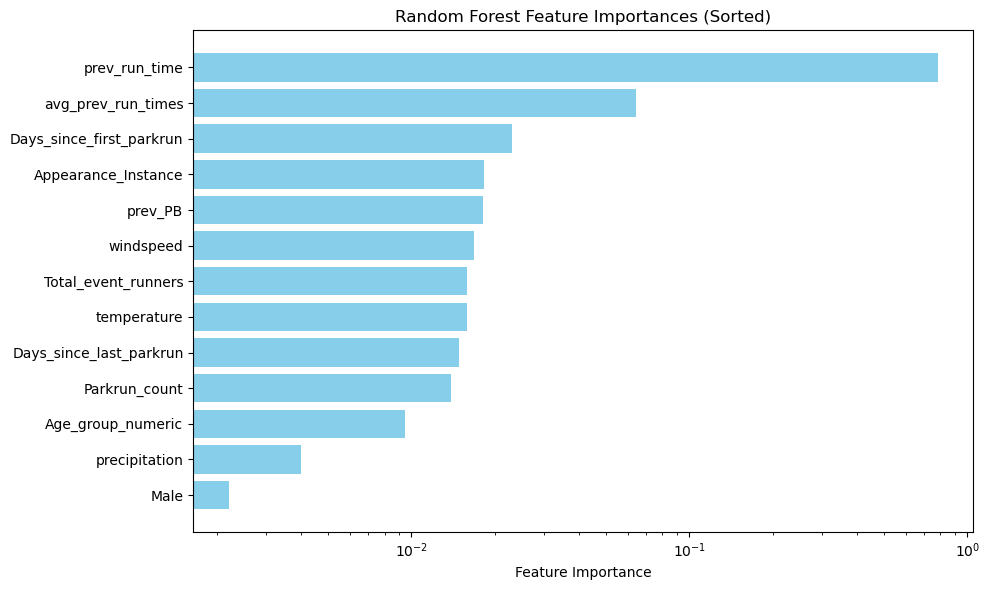

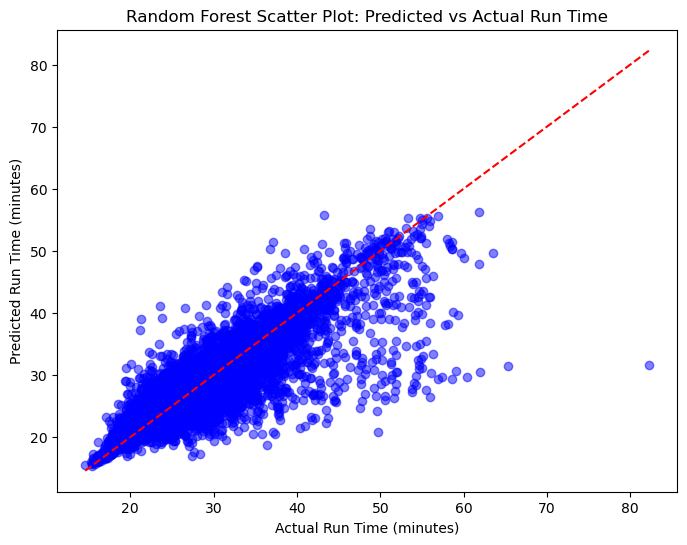

[0.78347211 0.06417558 0.02299578 0.01824911 0.01814898 0.01674333
 0.01588614 0.01587335 0.01484145 0.01392958 0.00948402 0.00400177
 0.0021988 ]


In [22]:
# Call functions to visualize feature importance and predicted vs actual
rf_features = plot_feature_importance(rf, X_train_norm_df.columns, 'Random Forest')
plot_predicted_vs_actual(y_test, y_pred_rf, 'Random Forest')
print(rf_features)

In [24]:
# Initialize and train Linear Regression model
lr = LinearRegression()
lr.fit(X_train_norm_df, y_train)

with open('models/linear_regression_initial_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

# Predict on test set
y_pred_lr = lr.predict(X_test_norm_df)

# Evaluate the model
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression - RMSE: {rmse_lr.round(3)}')
print(f'Linear Regression - R-squared: {r2_lr.round(3)}')


Linear Regression - RMSE: 2.379
Linear Regression - R-squared: 0.803


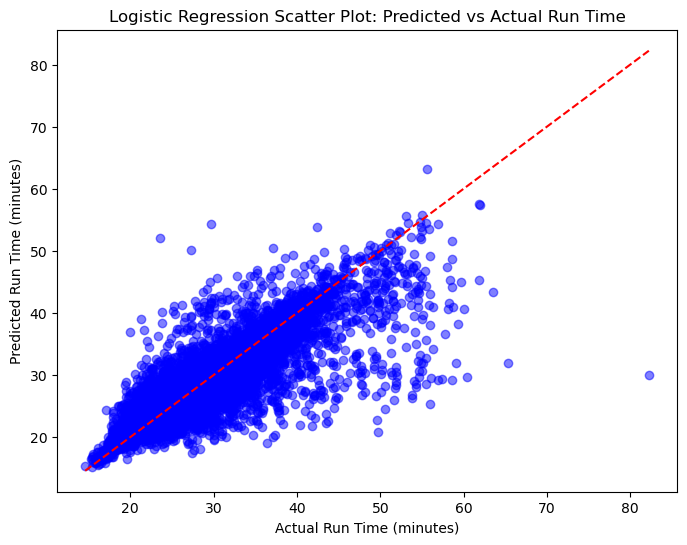

In [26]:
# Visualize results
plot_predicted_vs_actual(y_test, y_pred_lr, 'Logistic Regression')

In [28]:
# Initialize and train Gradient Boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=0)
gb.fit(X_train_norm_df, y_train)

with open('models/gradient_boosting_initial_model.pkl', 'wb') as f:
    pickle.dump(gb, f)

# Predict on test set
y_pred_gb = gb.predict(X_test_norm_df)

# Evaluate the model
rmse_gb = root_mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting - RMSE: {rmse_gb.round(3)}')
print(f'Gradient Boosting - R-squared: {r2_gb.round(3)}')


Gradient Boosting - RMSE: 2.296
Gradient Boosting - R-squared: 0.817


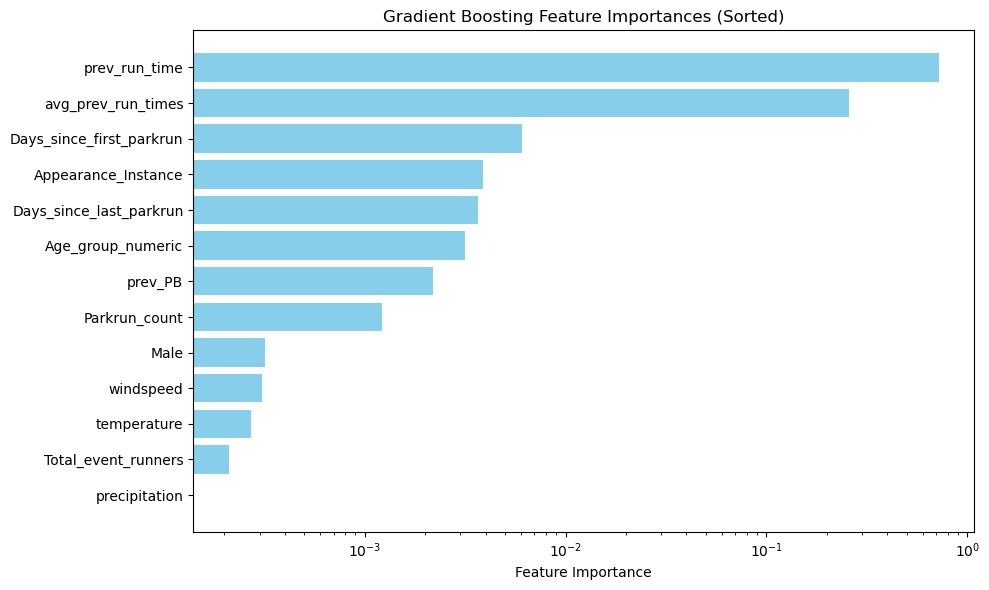

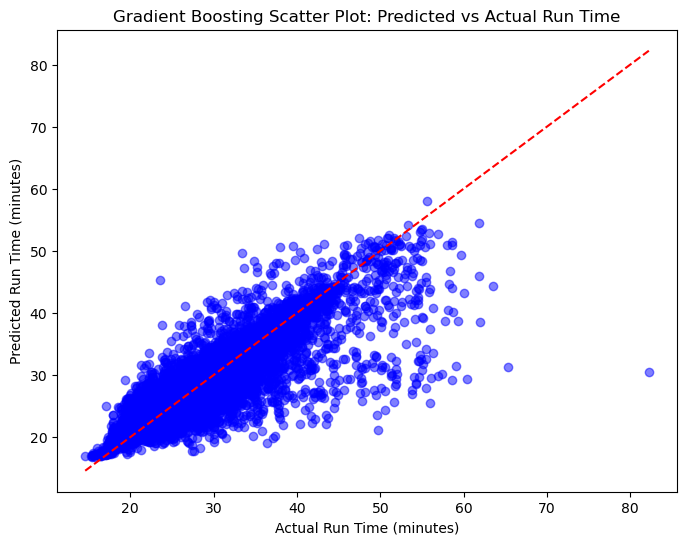

In [29]:
# Visualize results
gb_features = plot_feature_importance(gb, X_train_norm_df.columns, 'Gradient Boosting')
plot_predicted_vs_actual(y_test, y_pred_gb, 'Gradient Boosting')

In [30]:
# Initialize and train XGBoost model
xg = xgb.XGBRegressor(n_estimators=100, random_state=0)
xg.fit(X_train_norm_df, y_train)

with open('models/xgb_initial_model.pkl', 'wb') as f:
    pickle.dump(xg, f)

# Predict on test set
y_pred_xg = xg.predict(X_test_norm_df)

# Evaluate the model
rmse_xg = root_mean_squared_error(y_test, y_pred_xg)
r2_xg = r2_score(y_test, y_pred_xg)

print(f'XGBoost - RMSE: {rmse_xg.round(3)}')
print(f'XGBoost - R-squared: {r2_xg.round(3)}')


XGBoost - RMSE: 2.248
XGBoost - R-squared: 0.824


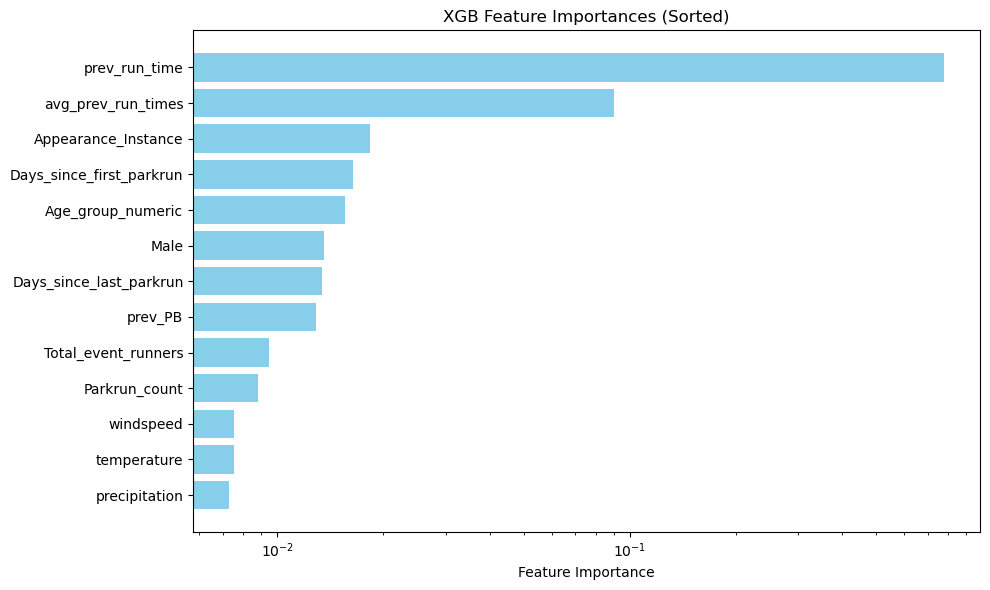

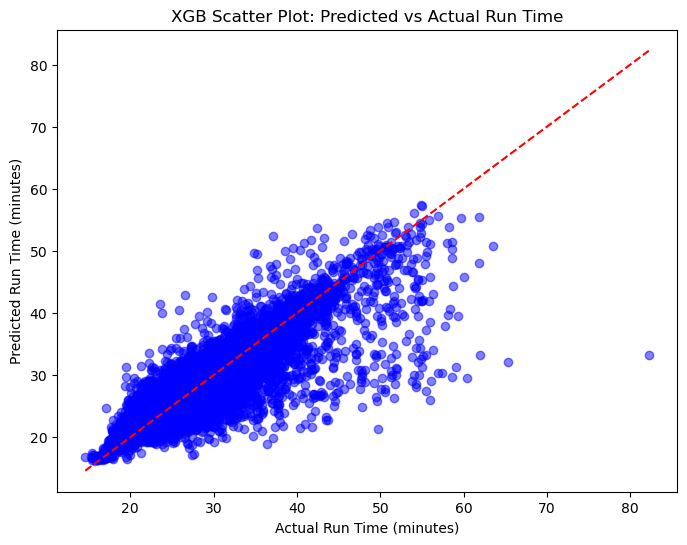

In [31]:
# Visualize results
xg_features = plot_feature_importance(xg, X_train_norm_df.columns, 'XGB')
plot_predicted_vs_actual(y_test, y_pred_xg, 'XGB')

In [46]:
# Initialize and train KNN model
knn = KNeighborsRegressor(n_neighbors=7, weights='distance')
knn.fit(X_train_norm_df, y_train)

# Predict on test set
y_pred_knn = knn.predict(X_test_norm_df)

with open('models/knn_initial_model.pkl', 'wb') as f:
    pickle.dump(knn, f)

# Evaluate the model
rmse_knn = root_mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f'KNN - RMSE: {rmse_knn.round(3)}')
print(f'KNN - R-squared: {r2_knn.round(3)}')


KNN - RMSE: 2.573
KNN - R-squared: 0.77


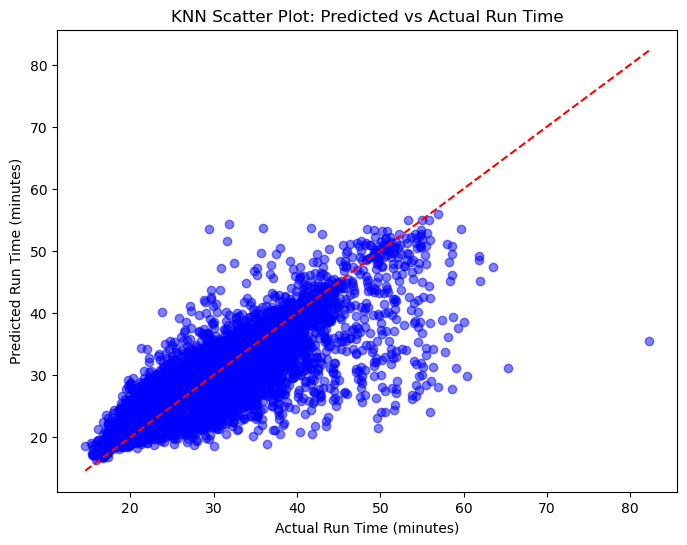

In [48]:
# Visualize results
plot_predicted_vs_actual(y_test, y_pred_knn, 'KNN')

In [50]:
print(f'KNN - RMSE: {rmse_knn.round(3)}')
print(f'KNN - R-squared: {r2_knn.round(3)}')
print('')
print(f'XGBoost - RMSE: {rmse_xg.round(3)}')
print(f'XGBoost - R-squared: {r2_xg.round(3)}')
print('')
print(f'Gradient Boosting - RMSE: {rmse_gb.round(3)}')
print(f'Gradient Boosting - R-squared: {r2_gb.round(3)}')
print('')
print(f'Linear Regression - RMSE: {rmse_lr.round(3)}')
print(f'Linear Regression - R-squared: {r2_lr.round(3)}')
print('')
print(f'Random Forest - RMSE: {rmse.round(3)}')
print(f'Random Forest - R-squared: {r2.round(3)}')

KNN - RMSE: 2.573
KNN - R-squared: 0.77

XGBoost - RMSE: 2.248
XGBoost - R-squared: 0.824

Gradient Boosting - RMSE: 2.296
Gradient Boosting - R-squared: 0.817

Linear Regression - RMSE: 2.379
Linear Regression - R-squared: 0.803

Random Forest - RMSE: 2.275
Random Forest - R-squared: 0.82


In [64]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the model
xgb = XGBRegressor(random_state=0)

# Define a smaller, more efficient parameter grid
params = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.02, 0.05, 0.1],  
    'max_depth': [3, 5, 7]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=params, cv=3, scoring='r2', n_jobs=-1, verbose=2)

# Run the grid search and print the progress manually
grid_search.fit(X_train_norm_df, y_train)

# Now that grid search is complete, we can access cv_results_
total_combinations = len(grid_search.cv_results_['params'])

# Print progress
for i, params in enumerate(grid_search.cv_results_['params']):
    print(f"Testing model {i + 1} out of {total_combinations} with parameters: {params}")

# Best parameters found
print("Best Parameters:", grid_search.best_params_)
print("Best R-squared:", grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Testing model 1 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 100}
Testing model 2 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 200}
Testing model 3 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 300}
Testing model 4 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 100}
Testing model 5 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 200}
Testing model 6 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 300}
Testing model 7 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 100}
Testing model 8 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 200}
Testing model 9 out of 27 with parameters: {'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 300}
Tes

Test RMSE: 2.245
Test R-squared: 0.825


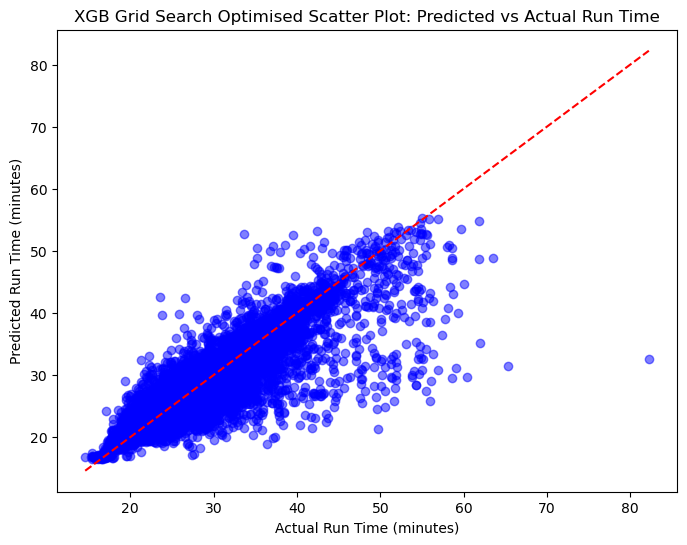

In [66]:
#colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0

# Retrieve the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = XGBRegressor(**best_params, random_state=0)
best_model.fit(X_train_norm_df, y_train)

with open('models/xgb_grid_search_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Predict on the test set
y_pred_xg_grid = best_model.predict(X_test_norm_df)

# Evaluate the model
rmse_xg = root_mean_squared_error(y_test, y_pred_xg_grid)
r2_xg = r2_score(y_test, y_pred_xg_grid)

print(f"Test RMSE: {rmse_xg:.3f}")
print(f"Test R-squared: {r2_xg:.3f}")

plot_predicted_vs_actual(y_test, y_pred_xg_grid, 'XGB Grid Search Optimised')

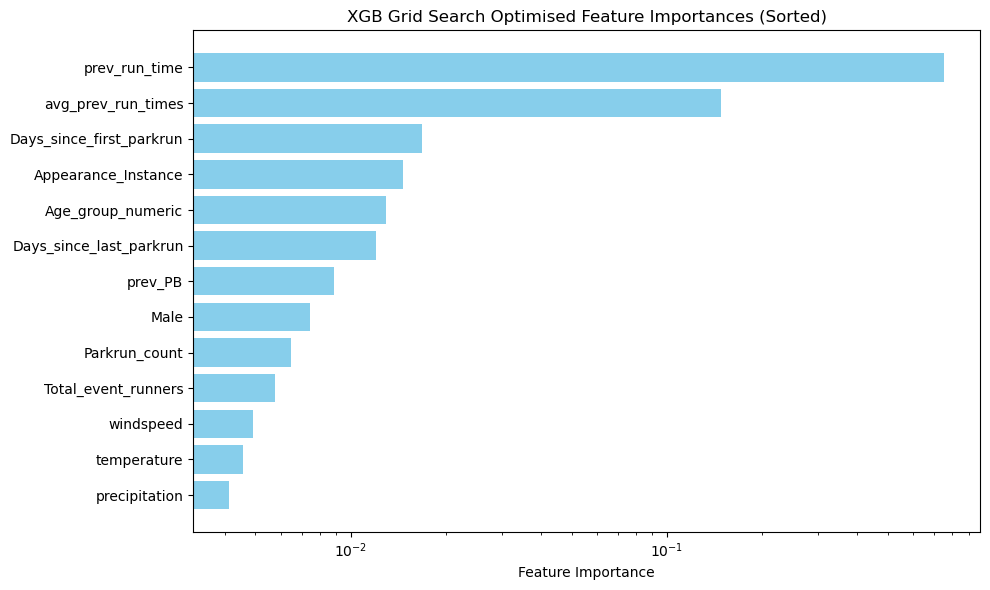

array([0.75354886, 0.14789473, 0.01683165, 0.01461104, 0.01292713,
       0.01201997, 0.00887993, 0.00746047, 0.0064887 , 0.00575631,
       0.00489617, 0.00456229, 0.00412272], dtype=float32)

In [72]:
xgb_grid_search_features = plot_feature_importance(best_model, X_train_norm_df.columns, 'XGB Grid Search Optimised')
xgb_grid_search_features

In [78]:
def objective(trial):
    # Define hyperparameter space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    # Create and evaluate the model
    model = XGBRegressor(**params, random_state=0)
    scores = cross_val_score(model, X_train_norm_df, y_train, 
                             cv=5, scoring=make_scorer(r2_score, greater_is_better=True))
    
    return np.mean(scores)

In [80]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

# Best parameters and score
print("Best Parameters:", study.best_params)
print("Best R2:", study.best_value)

[I 2024-12-13 10:43:12,466] A new study created in memory with name: no-name-aeb5b52b-a67b-431a-8c64-78a5fd0d46d0
[I 2024-12-13 10:43:23,554] Trial 0 finished with value: 0.8264935418286115 and parameters: {'n_estimators': 242, 'max_depth': 5, 'learning_rate': 0.16497013374049463, 'subsample': 0.8703006911636384, 'colsample_bytree': 0.6545179664974219, 'gamma': 3.0012230164974008, 'reg_alpha': 0.1444460716846374, 'reg_lambda': 6.103691611356994}. Best is trial 0 with value: 0.8264935418286115.
[I 2024-12-13 10:43:31,665] Trial 1 finished with value: 0.8250166177431932 and parameters: {'n_estimators': 107, 'max_depth': 7, 'learning_rate': 0.14557776565807182, 'subsample': 0.6493902037910793, 'colsample_bytree': 0.9043664191154651, 'gamma': 1.217000152303374, 'reg_alpha': 5.957260686157725, 'reg_lambda': 1.3864813781557739}. Best is trial 0 with value: 0.8264935418286115.
[I 2024-12-13 10:43:37,765] Trial 2 finished with value: 0.8226328592812309 and parameters: {'n_estimators': 100, 'ma

Best Parameters: {'n_estimators': 242, 'max_depth': 9, 'learning_rate': 0.0428684338496151, 'subsample': 0.8778171843286946, 'colsample_bytree': 0.6012349454688508, 'gamma': 3.029645157964912, 'reg_alpha': 6.767120100778456, 'reg_lambda': 2.9052280530735892}
Best R2: 0.8299723901744251


In [85]:
# Train final model with best parameters
best_params = study.best_params
best_xgb_model = XGBRegressor(**best_params, random_state=0)
best_xgb_model.fit(X_train_norm_df, y_train)

with open('models/xgb_opt_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

# Evaluate on test data
y_pred_opt_test = best_xgb_model.predict(X_test_norm_df)
rmse_opt_test = root_mean_squared_error(y_test, y_pred_opt_test)
r2_opt_test = r2_score(y_test, y_pred_opt_test)

# Evaluate on training data
y_pred_opt_train = best_xgb_model.predict(X_train_norm_df)
rmse_opt_train = root_mean_squared_error(y_train, y_pred_opt_train)
r2_opt_train = r2_score(y_train, y_pred_opt_train)

# Print results
print(f"Training RMSE: {rmse_opt_train:.3f}")
print(f"Training R-squared: {r2_opt_train:.3f}")
print("")
print(f"Test RMSE: {rmse_opt_test:.3f}")
print(f"Test R-squared: {r2_opt_test:.3f}")

plot_predicted_vs_actual(y_test, y_pred_opt_test, 'Optimised XGB')
best_xgb_features = plot_feature_importance(best_xgb_model, X_train_norm_df.columns, 'XGB Optimised')

Training RMSE: 1.853
Training R-squared: 0.885

Test RMSE: 2.207
Test R-squared: 0.831


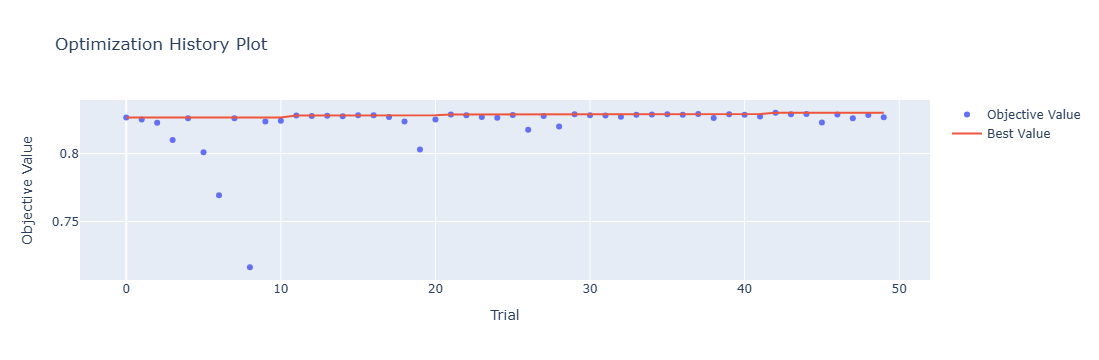

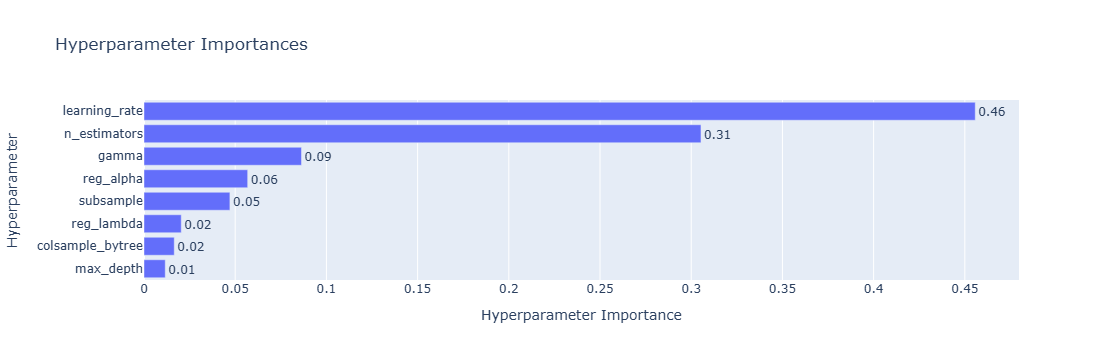

In [87]:
plot_optimization_history(study).show()
plot_param_importances(study).show()

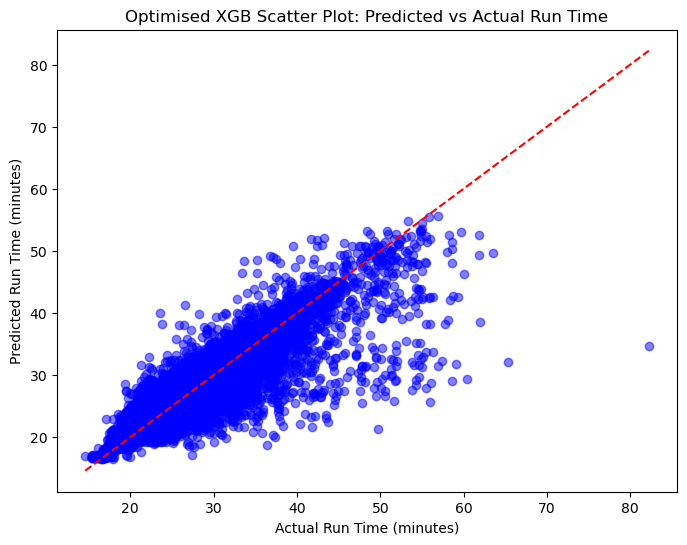

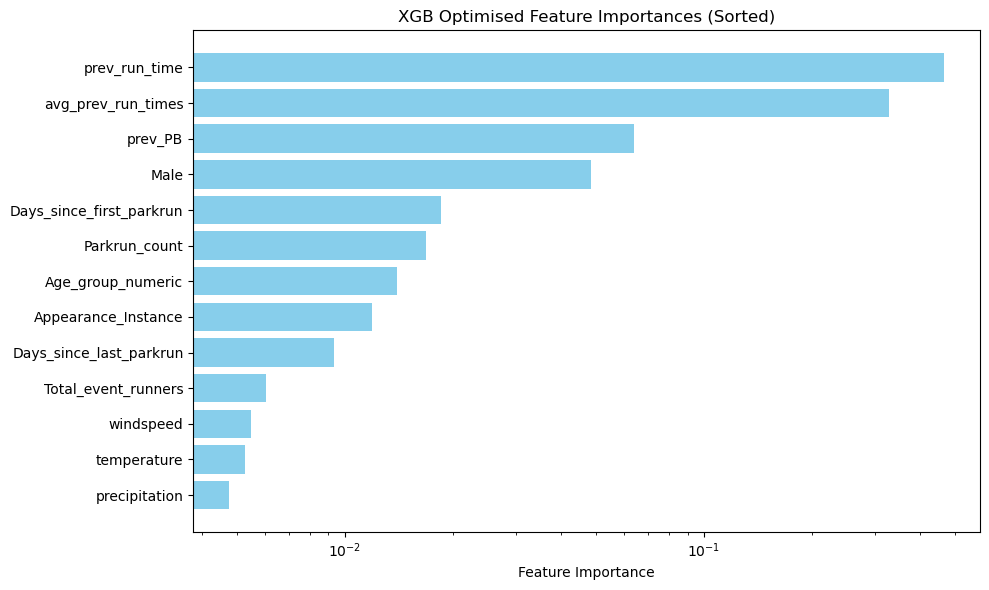

In [89]:
plot_predicted_vs_actual(y_test, y_pred_opt_test, 'Optimised XGB')
best_xgb_features = plot_feature_importance(best_xgb_model, X_train_norm_df.columns, 'XGB Optimised')

In [91]:
# Use RFE for feature selection
rfe = RFE(estimator=best_xgb_model, n_features_to_select=5)

# Fit the RFE model and track progress manually
num_features = X_train_norm_df.shape[1]  # Total number of features
print(f"Starting RFE with {num_features} features. Progress will be displayed...")

# Fit the RFE model and track iterations
for i in range(num_features, 0, -1):  # RFE reduces features, start from the full set
    rfe.n_features_to_select = i  # Reduce the number of features in each iteration
    rfe.fit(X_train_norm_df, y_train)
    
    # After each iteration, print the progress
    print(f"RFE iteration {num_features - i + 1}/{num_features}: {i} features remaining.")


# Get selected features and their rankings
selected_features = rfe.support_  # Boolean mask of selected features
feature_ranking = rfe.ranking_    # Feature ranking (1 means selected)

# Print results
print("Selected Features (True = Selected):", selected_features)
print("Feature Ranking:", feature_ranking)

Starting RFE with 13 features. Progress will be displayed...
RFE iteration 1/13: 13 features remaining.
RFE iteration 2/13: 12 features remaining.
RFE iteration 3/13: 11 features remaining.
RFE iteration 4/13: 10 features remaining.
RFE iteration 5/13: 9 features remaining.
RFE iteration 6/13: 8 features remaining.
RFE iteration 7/13: 7 features remaining.
RFE iteration 8/13: 6 features remaining.
RFE iteration 9/13: 5 features remaining.
RFE iteration 10/13: 4 features remaining.
RFE iteration 11/13: 3 features remaining.
RFE iteration 12/13: 2 features remaining.
RFE iteration 13/13: 1 features remaining.
Selected Features (True = Selected): [False False False False False False False  True False False False False
 False]
Feature Ranking: [ 8 12 10 13  4  9 11  1  2  3  7  6  5]


In [102]:
ranked_columns = [(col, rank) for col, rank in zip(X_train_norm_df.columns, feature_ranking)]

ranked_columns = sorted(ranked_columns, key=lambda x: x[1])
ranked_columns

[('prev_run_time', 1),
 ('prev_PB', 2),
 ('avg_prev_run_times', 3),
 ('Appearance_Instance', 4),
 ('Male', 5),
 ('Days_since_first_parkrun', 6),
 ('Age_group_numeric', 7),
 ('Parkrun_count', 8),
 ('Days_since_last_parkrun', 9),
 ('windspeed', 10),
 ('Total_event_runners', 11),
 ('temperature', 12),
 ('precipitation', 13)]

In [104]:
def optimize_and_train_model(sorted_features, X_train_norm_df, X_test_norm_df, y_train, y_test, model_save_path, top_n=6, n_trials=50):
    """
    Function to optimize an XGBoost model using Optuna, train it with the best parameters, 
    and evaluate it on training and test sets.

    Parameters:
    sorted_features: List of tuples containing feature names and their scores, sorted by importance.
    X_train_norm_df: DataFrame containing normalized training features.
    X_test_norm_df: DataFrame containing normalized test features.
    y_train: Training target variable.
    y_test: Test target variable.
    top_n: Number of top features to use for optimization. Default is 6.
    n_trials: Number of trials for Optuna optimization. Default is 50.
    model_save_path: Path to save the trained model.

    Returns:
    study: Optuna study object containing optimization results.
    best_model: Trained XGBoost model with the best parameters.
    """
    # Select top N features
    top_n_cols = [feature[0] for feature in sorted_features[:top_n]]
    filt_X_train_norm_df = X_train_norm_df[top_n_cols]
    filt_X_test_norm_df = X_test_norm_df[top_n_cols]

    # Define the objective function for Optuna
    def objective(trial):
        # Define hyperparameter space
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        }

        # Create and evaluate the model
        model = XGBRegressor(**params, random_state=0)
        scores = cross_val_score(
            model, filt_X_train_norm_df, y_train, 
            cv=5, scoring=make_scorer(r2_score, greater_is_better=True)
        )
        return np.mean(scores)

    # Run the Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Train the final model with the best parameters
    best_params = study.best_params
    best_model = XGBRegressor(**best_params, random_state=0)
    best_model.fit(filt_X_train_norm_df, y_train)

    # Save the trained model
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_model, f)

    # Evaluate on test data
    y_pred_test = best_model.predict(filt_X_test_norm_df)
    rmse_test = np.sqrt(np.mean((y_test - y_pred_test) ** 2))  # Root Mean Squared Error
    r2_test = r2_score(y_test, y_pred_test)

    # Evaluate on training data
    y_pred_train = best_model.predict(filt_X_train_norm_df)
    rmse_train = np.sqrt(np.mean((y_train - y_pred_train) ** 2))  # Root Mean Squared Error
    r2_train = r2_score(y_train, y_pred_train)

    # Print results
    print(f"Top {top_n} Features Used: {top_n_cols}")
    print("Best Parameters:", best_params)
    print("")
    print(f"Training RMSE: {rmse_train:.3f}")
    print(f"Training R-squared: {r2_train:.3f}")
    print("")
    print(f"Test RMSE: {rmse_test:.3f}")
    print(f"Test R-squared: {r2_test:.3f}")

    return study, best_model

In [113]:
study5, best_model5 = optimize_and_train_model(
    top_n=5,
    model_save_path="models/xgb_opt_5_features_model.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=25,    
)

[I 2024-12-13 11:19:01,464] A new study created in memory with name: no-name-abc1eb8a-5243-4eea-afbc-d5317b6fd7ba
[I 2024-12-13 11:19:19,168] Trial 0 finished with value: 0.8138635052848621 and parameters: {'n_estimators': 279, 'max_depth': 9, 'learning_rate': 0.17463874938364726, 'subsample': 0.9262142751310076, 'colsample_bytree': 0.9795080325022238, 'gamma': 1.4091530610905323, 'reg_alpha': 7.8019254324586615, 'reg_lambda': 6.661355386352321}. Best is trial 0 with value: 0.8138635052848621.
[I 2024-12-13 11:19:39,092] Trial 1 finished with value: 0.816230717261325 and parameters: {'n_estimators': 285, 'max_depth': 9, 'learning_rate': 0.07061319214993103, 'subsample': 0.7851077545723137, 'colsample_bytree': 0.6468000366290324, 'gamma': 2.0188676132474055, 'reg_alpha': 6.183315692830808, 'reg_lambda': 1.4925011058026372}. Best is trial 1 with value: 0.816230717261325.
[I 2024-12-13 11:19:55,437] Trial 2 finished with value: 0.8187708093329519 and parameters: {'n_estimators': 191, 'max

Top 5 Features Used: ['prev_run_time', 'prev_PB', 'avg_prev_run_times', 'Appearance_Instance', 'Male']
Best Parameters: {'n_estimators': 154, 'max_depth': 10, 'learning_rate': 0.02961659443573205, 'subsample': 0.6635298758287187, 'colsample_bytree': 0.8050558307427398, 'gamma': 4.369690427486156, 'reg_alpha': 2.6648204029980285, 'reg_lambda': 4.517619801556453}

Training RMSE: 2.114
Training R-squared: 0.851

Test RMSE: 2.268
Test R-squared: 0.821


In [114]:
study6, best_model6 = optimize_and_train_model(
    top_n=6,
    model_save_path="models/xgb_opt_6_features_model.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=25,    
)


[I 2024-12-13 11:23:34,400] A new study created in memory with name: no-name-c14e3ec9-d3f5-4548-9d02-5d51545d1226
[I 2024-12-13 11:23:47,367] Trial 0 finished with value: 0.8216734644665085 and parameters: {'n_estimators': 245, 'max_depth': 7, 'learning_rate': 0.03670754936379643, 'subsample': 0.995906349963486, 'colsample_bytree': 0.9453950602509846, 'gamma': 4.6921512733339465, 'reg_alpha': 3.4009352407942792, 'reg_lambda': 1.1379543328524577}. Best is trial 0 with value: 0.8216734644665085.
[I 2024-12-13 11:23:55,897] Trial 1 finished with value: 0.8189549300265497 and parameters: {'n_estimators': 255, 'max_depth': 3, 'learning_rate': 0.2712878059215655, 'subsample': 0.6913913461703296, 'colsample_bytree': 0.6097296588030595, 'gamma': 1.3118018193151126, 'reg_alpha': 4.016797100927391, 'reg_lambda': 9.085175158240155}. Best is trial 0 with value: 0.8216734644665085.
[I 2024-12-13 11:24:00,961] Trial 2 finished with value: 0.820842129667723 and parameters: {'n_estimators': 91, 'max_d

Top 6 Features Used: ['prev_run_time', 'prev_PB', 'avg_prev_run_times', 'Appearance_Instance', 'Male', 'Days_since_first_parkrun']
Best Parameters: {'n_estimators': 232, 'max_depth': 10, 'learning_rate': 0.02833182170765121, 'subsample': 0.8789497793763539, 'colsample_bytree': 0.7926967973031344, 'gamma': 2.7496214078905212, 'reg_alpha': 5.707578066774293, 'reg_lambda': 5.588956905920952}

Training RMSE: 2.041
Training R-squared: 0.861

Test RMSE: 2.239
Test R-squared: 0.826


In [115]:
study7, best_model7 = optimize_and_train_model(
    top_n=7,
    model_save_path="models/xgb_opt_7_features_model.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=25,    
)


[I 2024-12-13 11:30:33,137] A new study created in memory with name: no-name-dab88ee2-7923-4ba0-9083-b0bca8d1820e
[I 2024-12-13 11:30:43,925] Trial 0 finished with value: 0.8222238261570324 and parameters: {'n_estimators': 289, 'max_depth': 4, 'learning_rate': 0.15735380492751794, 'subsample': 0.8937975385963677, 'colsample_bytree': 0.9578516517159702, 'gamma': 1.3635012530688528, 'reg_alpha': 8.096331367627705, 'reg_lambda': 4.484107806565122}. Best is trial 0 with value: 0.8222238261570324.
[I 2024-12-13 11:30:54,031] Trial 1 finished with value: 0.8222090855259196 and parameters: {'n_estimators': 157, 'max_depth': 7, 'learning_rate': 0.05690861780123672, 'subsample': 0.6350784316972271, 'colsample_bytree': 0.9250824849958277, 'gamma': 1.2890984093383624, 'reg_alpha': 0.9715740798359807, 'reg_lambda': 0.31012666880909645}. Best is trial 0 with value: 0.8222238261570324.
[I 2024-12-13 11:31:09,084] Trial 2 finished with value: 0.8232863402186832 and parameters: {'n_estimators': 148, '

Top 7 Features Used: ['prev_run_time', 'prev_PB', 'avg_prev_run_times', 'Appearance_Instance', 'Male', 'Days_since_first_parkrun', 'Age_group_numeric']
Best Parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.09720991231702122, 'subsample': 0.8713328873234264, 'colsample_bytree': 0.6884762624138815, 'gamma': 3.3025387147322185, 'reg_alpha': 5.98857936731611, 'reg_lambda': 9.483190442101481}

Training RMSE: 2.127
Training R-squared: 0.849

Test RMSE: 2.243
Test R-squared: 0.825


In [116]:

study8, best_model8 = optimize_and_train_model(
    top_n=8,
    model_save_path="models/xgb_opt_8_features_model.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=25,    
)

[I 2024-12-13 11:34:42,353] A new study created in memory with name: no-name-129d4d59-f74c-44a8-82bd-b272469a71e5
[I 2024-12-13 11:34:53,805] Trial 0 finished with value: 0.8092775062748908 and parameters: {'n_estimators': 131, 'max_depth': 9, 'learning_rate': 0.25800271442934136, 'subsample': 0.6550991504183622, 'colsample_bytree': 0.8796687866691053, 'gamma': 1.3457316354992384, 'reg_alpha': 5.043336968435328, 'reg_lambda': 1.0017075631454164}. Best is trial 0 with value: 0.8092775062748908.
[I 2024-12-13 11:35:09,964] Trial 1 finished with value: 0.8124567593577741 and parameters: {'n_estimators': 158, 'max_depth': 9, 'learning_rate': 0.014364170494228725, 'subsample': 0.8903320001470175, 'colsample_bytree': 0.8930766738514985, 'gamma': 4.0719271882204175, 'reg_alpha': 5.916185812815033, 'reg_lambda': 4.755301019937411}. Best is trial 1 with value: 0.8124567593577741.
[I 2024-12-13 11:35:19,125] Trial 2 finished with value: 0.6845063104269732 and parameters: {'n_estimators': 68, 'ma

Top 8 Features Used: ['prev_run_time', 'prev_PB', 'avg_prev_run_times', 'Appearance_Instance', 'Male', 'Days_since_first_parkrun', 'Age_group_numeric', 'Parkrun_count']
Best Parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.04041241185868307, 'subsample': 0.6811811460677553, 'colsample_bytree': 0.6367327356474017, 'gamma': 0.7320334657611007, 'reg_alpha': 0.9693276907929476, 'reg_lambda': 8.633031442219723}

Training RMSE: 2.016
Training R-squared: 0.864

Test RMSE: 2.224
Test R-squared: 0.828


In [117]:
study9, best_model9 = optimize_and_train_model(
    top_n=9,
    model_save_path="models/xgb_opt_9_features_model.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=25,    
)

[I 2024-12-13 11:40:53,395] A new study created in memory with name: no-name-701d51f1-3467-42e6-aa19-807e8129484f
[I 2024-12-13 11:41:02,841] Trial 0 finished with value: 0.8230603749214922 and parameters: {'n_estimators': 261, 'max_depth': 3, 'learning_rate': 0.25293466152205346, 'subsample': 0.6496005076314648, 'colsample_bytree': 0.7523079173531717, 'gamma': 0.12821269570059024, 'reg_alpha': 0.4185950482448386, 'reg_lambda': 2.7508039406661453}. Best is trial 0 with value: 0.8230603749214922.
[I 2024-12-13 11:41:07,611] Trial 1 finished with value: 0.8135888902769413 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.03506795083346729, 'subsample': 0.6571423119855703, 'colsample_bytree': 0.7989339367657378, 'gamma': 0.48972960728966175, 'reg_alpha': 0.07005948867935041, 'reg_lambda': 0.5474385212623123}. Best is trial 0 with value: 0.8230603749214922.
[I 2024-12-13 11:41:27,135] Trial 2 finished with value: 0.8276203922718721 and parameters: {'n_estimators': 153

Top 9 Features Used: ['prev_run_time', 'prev_PB', 'avg_prev_run_times', 'Appearance_Instance', 'Male', 'Days_since_first_parkrun', 'Age_group_numeric', 'Parkrun_count', 'Days_since_last_parkrun']
Best Parameters: {'n_estimators': 296, 'max_depth': 8, 'learning_rate': 0.05183508263364046, 'subsample': 0.7125588126243594, 'colsample_bytree': 0.6809060658697705, 'gamma': 4.072745663004381, 'reg_alpha': 7.347985987261437, 'reg_lambda': 6.3999014623463}

Training RMSE: 2.002
Training R-squared: 0.866

Test RMSE: 2.209
Test R-squared: 0.830


In [144]:
def evaluate_model(model, feature_count, title, ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test):
    # Select top N features based on sorted feature ranking
    top_n_cols = [feature[0] for feature in ranked_columns[:feature_count]]
    
    # Ensure columns are available in both training and test data
    X_train_selected = X_train_norm_df[top_n_cols]
    X_test_selected = X_test_norm_df[top_n_cols]  # Use the same columns for the test set
    
    # Predict on test data
    y_pred = model.predict(X_test_selected)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Predict on training data with selected features
    y_pred_train = model.predict(X_train_selected)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Print results
    print(f"Training RMSE: {rmse_train:.3f}")
    print(f"Training R-squared: {r2_train:.3f}")
    print("")
    print(f"Test RMSE: {rmse:.3f}")
    print(f"Test R-squared: {r2:.3f}")
    
    # Plot predicted vs actual for test set
    plot_predicted_vs_actual(y_test, y_pred, title)
    
    return best_xgb_features

Training RMSE: 2.114
Training R-squared: 0.851

Test RMSE: 2.268
Test R-squared: 0.821


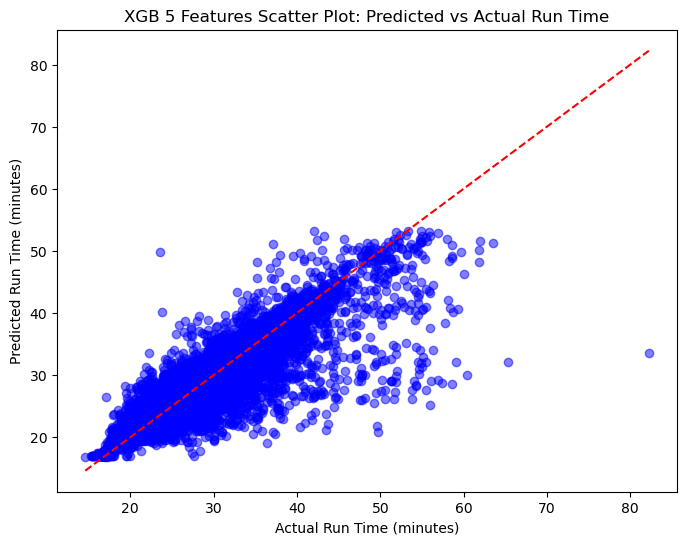

array([0.4669463 , 0.3285047 , 0.06405212, 0.04843341, 0.01853297,
       0.01682477, 0.01398917, 0.01187029, 0.00934392, 0.00601827,
       0.00547419, 0.00525485, 0.00475503], dtype=float32)

In [146]:
evaluate_model(best_model5, 5, 'XGB 5 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)

Training RMSE: 2.041
Training R-squared: 0.861

Test RMSE: 2.239
Test R-squared: 0.826


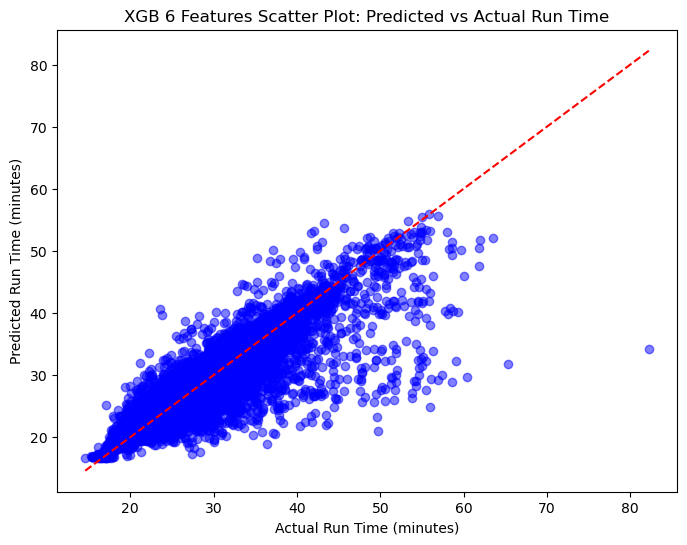

array([0.4669463 , 0.3285047 , 0.06405212, 0.04843341, 0.01853297,
       0.01682477, 0.01398917, 0.01187029, 0.00934392, 0.00601827,
       0.00547419, 0.00525485, 0.00475503], dtype=float32)

In [148]:
evaluate_model(best_model6, 6, 'XGB 6 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)

Training RMSE: 2.127
Training R-squared: 0.849

Test RMSE: 2.243
Test R-squared: 0.825


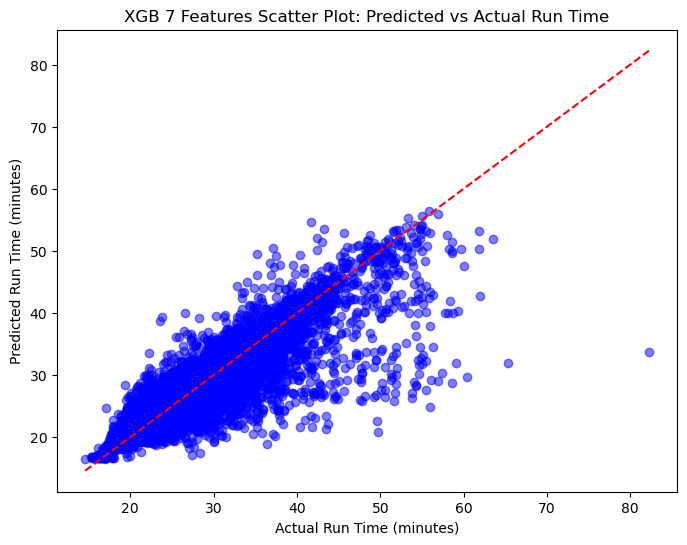

array([0.4669463 , 0.3285047 , 0.06405212, 0.04843341, 0.01853297,
       0.01682477, 0.01398917, 0.01187029, 0.00934392, 0.00601827,
       0.00547419, 0.00525485, 0.00475503], dtype=float32)

In [150]:
evaluate_model(best_model7, 7, 'XGB 7 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)

Training RMSE: 2.016
Training R-squared: 0.864

Test RMSE: 2.224
Test R-squared: 0.828


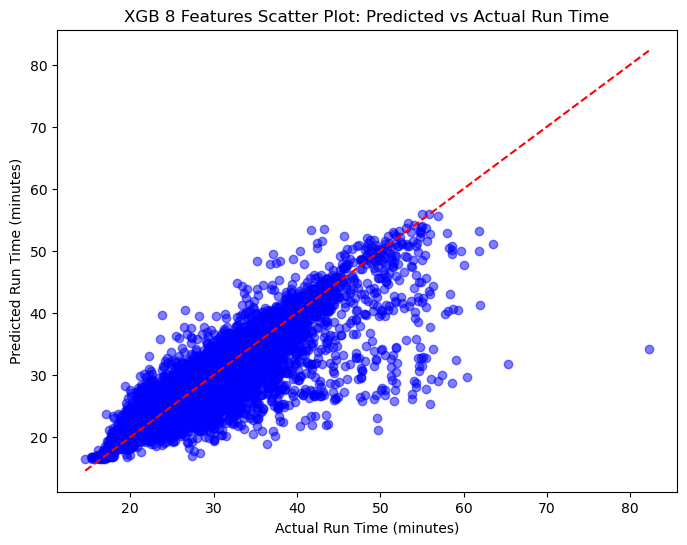

array([0.4669463 , 0.3285047 , 0.06405212, 0.04843341, 0.01853297,
       0.01682477, 0.01398917, 0.01187029, 0.00934392, 0.00601827,
       0.00547419, 0.00525485, 0.00475503], dtype=float32)

In [152]:
evaluate_model(best_model8, 8, 'XGB 8 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)

Training RMSE: 2.002
Training R-squared: 0.866

Test RMSE: 2.209
Test R-squared: 0.830


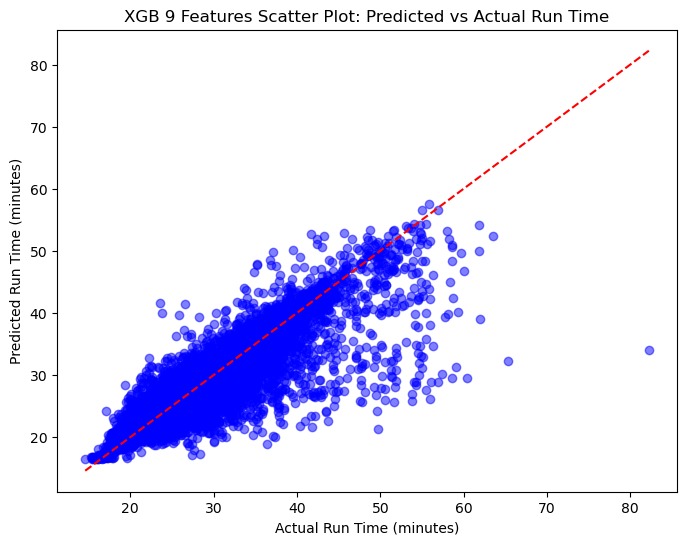

array([0.4669463 , 0.3285047 , 0.06405212, 0.04843341, 0.01853297,
       0.01682477, 0.01398917, 0.01187029, 0.00934392, 0.00601827,
       0.00547419, 0.00525485, 0.00475503], dtype=float32)

In [154]:
evaluate_model(best_model9, 9, 'XGB 9 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)

In [156]:
ranked_columns

[('prev_run_time', 1),
 ('prev_PB', 2),
 ('avg_prev_run_times', 3),
 ('Appearance_Instance', 4),
 ('Male', 5),
 ('Days_since_first_parkrun', 6),
 ('Age_group_numeric', 7),
 ('Parkrun_count', 8),
 ('Days_since_last_parkrun', 9),
 ('windspeed', 10),
 ('Total_event_runners', 11),
 ('temperature', 12),
 ('precipitation', 13)]

[I 2024-12-13 12:00:41,095] A new study created in memory with name: no-name-3932b28a-7525-4fae-9c0b-cf65af394c5b
[I 2024-12-13 12:00:56,683] Trial 0 finished with value: 0.8238042694836075 and parameters: {'n_estimators': 223, 'max_depth': 7, 'learning_rate': 0.2504072612277375, 'subsample': 0.9458321041547513, 'colsample_bytree': 0.8182633983687495, 'gamma': 0.32490071800163944, 'reg_alpha': 7.942084663352635, 'reg_lambda': 6.756126612516766}. Best is trial 0 with value: 0.8238042694836075.
[I 2024-12-13 12:01:04,036] Trial 1 finished with value: 0.7511341051816951 and parameters: {'n_estimators': 139, 'max_depth': 4, 'learning_rate': 0.01006089374836425, 'subsample': 0.9327426844387825, 'colsample_bytree': 0.9142672248546709, 'gamma': 1.008148510487562, 'reg_alpha': 4.782883609540095, 'reg_lambda': 7.764920153639588}. Best is trial 0 with value: 0.8238042694836075.
[I 2024-12-13 12:01:14,452] Trial 2 finished with value: 0.8215188664512982 and parameters: {'n_estimators': 251, 'max_

Top 10 Features Used: ['prev_run_time', 'prev_PB', 'avg_prev_run_times', 'Appearance_Instance', 'Male', 'Days_since_first_parkrun', 'Age_group_numeric', 'Parkrun_count', 'Days_since_last_parkrun', 'windspeed']
Best Parameters: {'n_estimators': 264, 'max_depth': 9, 'learning_rate': 0.028550175830154657, 'subsample': 0.6800457471531034, 'colsample_bytree': 0.6774582099430216, 'gamma': 2.6429457357532073, 'reg_alpha': 3.134796327381141, 'reg_lambda': 2.8655139020445035}

Training RMSE: 1.936
Training R-squared: 0.875

Test RMSE: 2.209
Test R-squared: 0.830
Training RMSE: 1.936
Training R-squared: 0.875

Test RMSE: 2.209
Test R-squared: 0.830


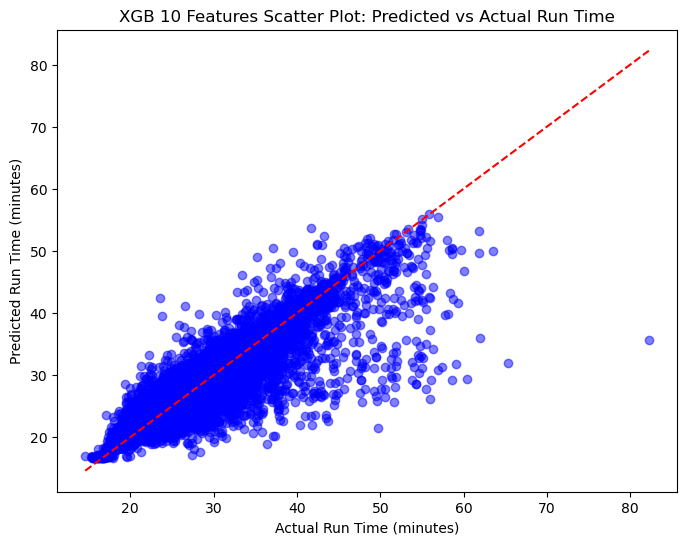

array([0.4669463 , 0.3285047 , 0.06405212, 0.04843341, 0.01853297,
       0.01682477, 0.01398917, 0.01187029, 0.00934392, 0.00601827,
       0.00547419, 0.00525485, 0.00475503], dtype=float32)

In [158]:
study10, best_model10 = optimize_and_train_model(
    top_n=10,
    model_save_path="models/xgb_opt_10_features_model.pkl",
    sorted_features=ranked_columns,
    X_train_norm_df=X_train_norm_df,
    X_test_norm_df=X_test_norm_df,
    y_train=y_train,
    y_test=y_test,
    n_trials=25,    
)

evaluate_model(best_model10, 10, 'XGB 10 Features', ranked_columns, X_train_norm_df, y_train, X_test_norm_df, y_test)